In [1]:
import numpy as np
import seaborn as sns
import torch

import umap
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
from torch_geometric.utils import k_hop_subgraph,to_networkx,from_networkx
import matplotlib

import utils
import plots
from model_AE import reduction_AE
from model_GAT import Encoder,SenGAE,train_GAT
from model_Sencell import Sencell

import logging

logging.basicConfig(format='%(asctime)s.%(msecs)03d [%(levelname)s] [%(filename)s:%(lineno)d] %(message)s',
                    datefmt='# %Y-%m-%d %H:%M:%S')

logging.getLogger().setLevel(logging.DEBUG)
logger = logging.getLogger()

# Part 1: load and process data
data_path="/users/PCON0022/haocheng/Basu_lab/rmarkdown/SCB01S5.h5ad"
# cell_cluster_arr在画umap的时候用
adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data(data_path)
# plots.umapPlot(adata.obsm['X_umap'],clusters=cell_cluster_arr,labels=celltype_names)

new_data,markers_index,\
sen_gene_ls,nonsen_gene_ls,gene_names=utils.process_data(adata,cluster_cell_ls,cell_cluster_arr)

print(f'cell num: {new_data.shape[0]}, gene num: {new_data.shape[1]}')

gene_cell=new_data.X.toarray().T
graph_nx=utils.build_graph_nx(gene_cell,cell_cluster_arr,sen_gene_ls,nonsen_gene_ls,gene_names)
logger.info("Part 1, data loading and processing end!")

# Part 2: generate init embedding
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ',device)

retrain=False
if retrain:
    gene_embed,cell_embed=reduction_AE(gene_cell,device)
    logger.info(gene_embed.shape,cell_embed.shape)
    torch.save(gene_embed,'./gene.emb')
    torch.save(cell_embed,'./cell.emb')
else:
    gene_embed=torch.load('./gene.emb')
    cell_embed=torch.load('./cell.emb')

graph_nx=utils.add_nx_embedding(graph_nx,gene_embed,cell_embed)
graph_pyg=utils.build_graph_pyg(gene_cell,gene_embed,cell_embed)
logger.info("Part 2, AE end!")

# Part 3: train GAT
# graph_pyg=graph_pyg.to('cpu')
GAT_model=train_GAT(graph_nx,graph_pyg,device,retrain=False,resampling=False)
logger.info("Part 3, training GAT end!")



from sampling import identify_sencell_marker_graph
from sampling import sub_sampling_by_random
from model_Sencell import cell_optim,update_cell_embeddings,old_cell_optim

from sampling import identify_sengene_then_sencell


all_gene_ls=[]

list_sencell_cover=[]
list_sengene_cover=[]

def get_sencell_cover(old_sencell_dict,sencell_dict):
    set1=set(list(old_sencell_dict.keys()))
    set2=set(list(sencell_dict.keys()))
    set3=set1.intersection(set2)
    print('sencell cover:',len(set3)/len(set2))
    
    return len(set3)/len(set2)

def get_sengene_cover(old_sengene_ls,sengene_ls):
    set1=set(old_sengene_ls)
    set2=set(sengene_ls)
    set3=set1.intersection(set2)
    print('sengene cover:',len(set3)/len(set2))
    
    return len(set3)/len(set2)
    
    
cellmodel=Sencell().to(device)
optimizer = torch.optim.Adam(cellmodel.parameters(), lr=0.001, 
                                weight_decay=1e-3)



# 2022-11-22 09:06:34.934 [DEBUG] [attrs.py:77] Creating converter from 3 to 5


cluster 数量： 21
celltype names: ['Macrophages', 'T cell lineage', 'Unknown', 'B cell lineage', 'Innate lymphoid cell NK', 'AT2', 'Monocytes', 'Multiciliated lineage', 'Dendritic cells', 'EC capillary', 'Mast cells', 'Fibroblasts', 'Secretory', 'EC venous', 'Lymphatic EC mature', 'AT1', 'Basal', 'EC arterial', 'Myofibroblasts', 'None', 'Submucosal Secretory']
-----------------------  ----
Macrophages              6941
T cell lineage            749
Unknown                   618
B cell lineage            374
Innate lymphoid cell NK   327
AT2                       294
Monocytes                 228
Multiciliated lineage     194
Dendritic cells           177
EC capillary              138
Mast cells                100
Fibroblasts                93
Secretory                  86
EC venous                  74
Lymphatic EC mature        68
AT1                        27
Basal                      26
EC arterial                20
Myofibroblasts             17
None                        6
Submucosal

# 2022-11-22 09:06:41.117 [INFO] [3655344800.py:39] Part 1, data loading and processing end!


device:  cuda:0
the number of edges: 1745053
edge index:  torch.Size([2, 1745053])
node feature:  torch.Size([12803, 128])
Pyg graph: Data(x=[12803, 128], edge_index=[2, 3490106], y=[12803])


# 2022-11-22 09:06:44.895 [INFO] [3655344800.py:57] Part 2, AE end!
# 2022-11-22 09:06:44.904 [INFO] [3655344800.py:62] Part 3, training GAT end!


graph.is_directed(): False


In [2]:
all_marker_index=sen_gene_ls
    
sampled_graph,sencell_dict,nonsencell_dict,cell_clusters,big_graph_index_dict=sub_sampling_by_random(graph_nx,
                                                        sen_gene_ls,
                                                        nonsen_gene_ls,
                                                        GAT_model,
                                                        all_marker_index,
                                                        n_gene=len(all_marker_index),                                                        
                                                        gene_num=2245,cell_num=10558,
                                                        gene_rate=0.3,cell_rate=0.5,
                                                        debug=False)
old_sengene_indexs=all_marker_index
for epoch in range(10):
    logger.info(f"epoch: {epoch}")
    old_sencell_dict=sencell_dict
    cellmodel,sencell_dict,nonsencell_dict=cell_optim(cellmodel,optimizer,
                                                      sencell_dict,nonsencell_dict,device,
                                                     train=True)
    sampled_graph=update_cell_embeddings(sampled_graph,sencell_dict,nonsencell_dict)
    sencell_dict,nonsencell_dict, \
    sen_gene_indexs,nonsen_gene_indexs=identify_sengene_then_sencell(sampled_graph,GAT_model,
                                                                  sencell_dict,nonsencell_dict,
                                                                  cell_clusters,
                                                                  big_graph_index_dict,
                                                                  len(all_marker_index))

    get_sencell_cover(old_sencell_dict,sencell_dict)
    get_sengene_cover(old_sengene_indexs,sen_gene_indexs)
    old_sengene_indexs=sen_gene_indexs


Start sampling subgraph randomly ...
    Sengene num: 351, Nonsengen num: 351
subgraph total node num: (11260,)


# 2022-11-20 21:08:39.927 [INFO] [sampling.py:243] Calculate attentions ...


After sampling, gene num:  tensor(702)


# 2022-11-20 21:08:45.184 [INFO] [sampling.py:256] Calculate attentions end.
# 2022-11-20 21:10:09.069 [INFO] [899266323.py:14] epoch: 0


    Sencell num: 322, Nonsencell num: 3220
这一簇没有非老化细胞： 20
72.89014434814453
这一簇没有非老化细胞： 20
68.3803482055664
这一簇没有非老化细胞： 20
61.267642974853516
这一簇没有非老化细胞： 20
50.59109115600586
这一簇没有非老化细胞： 20
41.96284484863281
这一簇没有非老化细胞： 20
48.926246643066406
这一簇没有非老化细胞： 20
51.21592712402344
这一簇没有非老化细胞： 20
46.10930633544922
这一簇没有非老化细胞： 20
41.35186767578125
这一簇没有非老化细胞： 20
42.077491760253906
这一簇没有非老化细胞： 20
43.989810943603516
这一簇没有非老化细胞： 20
45.23898696899414
这一簇没有非老化细胞： 20
44.83336639404297
这一簇没有非老化细胞： 20
43.316368103027344
这一簇没有非老化细胞： 20
41.7119140625
这一簇没有非老化细胞： 20
40.39191436767578
这一簇没有非老化细胞： 20
40.28939437866211
这一簇没有非老化细胞： 20
41.381771087646484
这一簇没有非老化细胞： 20
41.68914794921875
这一簇没有非老化细胞： 20
40.63090515136719


# 2022-11-20 21:14:38.958 [INFO] [sampling.py:243] Calculate attentions ...
# 2022-11-20 21:14:44.244 [INFO] [sampling.py:256] Calculate attentions end.


rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-20 21:16:10.534 [INFO] [899266323.py:14] epoch: 1


    Sencell num: 537, Nonsencell num: 5370
sencell cover: 0.38361266294227186
sengene cover: 0.6068376068376068
53.32670211791992
53.21170425415039
52.90882110595703
52.41564178466797
51.71759033203125
50.78138732910156
49.56866455078125
48.01884078979492
46.068504333496094
43.62643051147461
40.604610443115234
36.939388275146484
32.60981369018555
29.692150115966797
31.955720901489258
35.12028121948242
36.40702438354492
35.66553497314453
33.55217361450195
30.971601486206055


# 2022-11-20 21:22:12.610 [INFO] [sampling.py:243] Calculate attentions ...
# 2022-11-20 21:22:17.869 [INFO] [sampling.py:256] Calculate attentions end.


rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-20 21:23:45.456 [INFO] [899266323.py:14] epoch: 2


    Sencell num: 623, Nonsencell num: 6230
sencell cover: 0.8234349919743178
sengene cover: 0.9088319088319088
38.34712219238281
39.44385528564453
39.968868255615234
40.04705047607422
39.74070358276367
39.052276611328125
37.95845031738281
36.431156158447266
34.469322204589844
32.06022644042969
29.3934383392334
27.12025260925293
26.86467170715332
28.30472755432129
29.915664672851562
30.797285079956055
30.661306381225586
29.648967742919922
28.15982437133789
26.743772506713867


# 2022-11-20 21:30:45.534 [INFO] [sampling.py:243] Calculate attentions ...
# 2022-11-20 21:30:50.997 [INFO] [sampling.py:256] Calculate attentions end.


rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-20 21:32:19.338 [INFO] [899266323.py:14] epoch: 3


    Sencell num: 614, Nonsencell num: 6140
sencell cover: 0.9478827361563518
sengene cover: 0.9259259259259259
27.293975830078125
28.190332412719727
28.582427978515625
28.52882957458496
28.073366165161133
27.249181747436523
26.142728805541992
24.876008987426758
23.510517120361328
22.170454025268555
21.39328956604004
21.401233673095703
21.985877990722656
22.75876235961914
23.3055419921875
23.3924617767334
23.027366638183594
22.39366340637207
21.75578498840332
21.31856346130371


# 2022-11-20 21:38:14.865 [INFO] [sampling.py:243] Calculate attentions ...
# 2022-11-20 21:38:20.285 [INFO] [sampling.py:256] Calculate attentions end.


rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-20 21:39:48.756 [INFO] [899266323.py:14] epoch: 4


    Sencell num: 612, Nonsencell num: 6120
sencell cover: 0.9934640522875817
sengene cover: 0.98005698005698
21.63834571838379
22.05950355529785
22.279279708862305
22.312780380249023
22.178430557250977
21.892641067504883
21.47635841369629
20.960691452026367
20.371742248535156
19.83111572265625
19.523582458496094
19.52310562133789
19.71965217590332
19.967674255371094
20.144376754760742
20.168243408203125
20.026485443115234
19.766876220703125
19.470277786254883
19.215177536010742


# 2022-11-20 21:45:16.626 [INFO] [sampling.py:243] Calculate attentions ...
# 2022-11-20 21:45:22.026 [INFO] [sampling.py:256] Calculate attentions end.


rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-20 21:46:50.675 [INFO] [899266323.py:14] epoch: 5


    Sencell num: 612, Nonsencell num: 6120
sencell cover: 1.0
sengene cover: 0.9971509971509972
20.56007957458496
20.74106216430664
20.727245330810547
20.540685653686523
20.200298309326172
19.750951766967773
19.296030044555664
18.983516693115234
18.93585205078125
19.085723876953125
19.2777099609375
19.398340225219727
19.399953842163086
19.28180694580078
19.08100128173828
18.86086082458496
18.69845962524414
18.636878967285156
18.66720199584961
18.744396209716797


# 2022-11-20 21:52:18.605 [INFO] [sampling.py:243] Calculate attentions ...
# 2022-11-20 21:52:23.724 [INFO] [sampling.py:256] Calculate attentions end.


rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-20 21:53:51.968 [INFO] [899266323.py:14] epoch: 6


    Sencell num: 613, Nonsencell num: 6130
sencell cover: 0.99836867862969
sengene cover: 1.0
21.743547439575195
21.695655822753906
21.4688663482666
21.08749771118164
20.575815200805664
19.944934844970703
19.23661994934082
18.6448917388916
18.469396591186523
18.711320877075195
19.101518630981445
19.4058780670166
19.50969696044922
19.395137786865234
19.116500854492188
18.779767990112305
18.50632667541504
18.389245986938477
18.437379837036133
18.580720901489258


# 2022-11-20 21:59:20.595 [INFO] [sampling.py:243] Calculate attentions ...
# 2022-11-20 21:59:25.719 [INFO] [sampling.py:256] Calculate attentions end.


rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-20 22:00:54.575 [INFO] [899266323.py:14] epoch: 7


    Sencell num: 612, Nonsencell num: 6120
sencell cover: 1.0
sengene cover: 1.0
24.061176300048828
24.0081729888916
23.653778076171875
23.05145835876465
22.29926872253418
21.44338035583496
20.487152099609375
19.48647117614746
18.647611618041992
18.423377990722656
18.91424560546875
19.493896484375
19.81902503967285
19.775110244750977
19.425682067871094
18.908920288085938
18.44996452331543
18.244474411010742
18.352907180786133
18.602785110473633


# 2022-11-20 22:06:22.616 [INFO] [sampling.py:243] Calculate attentions ...
# 2022-11-20 22:06:27.909 [INFO] [sampling.py:256] Calculate attentions end.


rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-20 22:07:56.237 [INFO] [899266323.py:14] epoch: 8


    Sencell num: 612, Nonsencell num: 6120
sencell cover: 1.0
sengene cover: 0.9971509971509972
28.28780174255371
28.162818908691406
27.53656768798828
26.43960952758789
24.915611267089844
23.036577224731445
21.13736915588379
19.329164505004883
18.136764526367188
18.957284927368164
20.55318260192871
21.439638137817383
21.209758758544922
20.113298416137695
18.78133773803711
18.003765106201172
18.24880599975586
18.827383041381836
19.293563842773438
19.49844741821289


# 2022-11-20 22:13:24.068 [INFO] [sampling.py:243] Calculate attentions ...
# 2022-11-20 22:13:29.120 [INFO] [sampling.py:256] Calculate attentions end.


rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-20 22:14:57.887 [INFO] [899266323.py:14] epoch: 9


    Sencell num: 613, Nonsencell num: 6130
sencell cover: 0.9967373572593801
sengene cover: 1.0
21.67387580871582
21.189390182495117
20.376022338867188
19.3174991607666
18.292238235473633
17.908782958984375
18.654008865356445
19.451744079589844
19.58016014099121
19.03022575378418
18.21156120300293
17.8188533782959
18.045429229736328
18.396894454956055
18.62126350402832
18.624210357666016
18.42293930053711
18.113731384277344
17.82649803161621
17.740859985351562


# 2022-11-20 22:20:25.924 [INFO] [sampling.py:243] Calculate attentions ...
# 2022-11-20 22:20:31.321 [INFO] [sampling.py:256] Calculate attentions end.


rechoice sengene num: 351 rechoice nonsengene num: 351
    Sencell num: 613, Nonsencell num: 6130
sencell cover: 1.0
sengene cover: 1.0


In [25]:
torch.save([sencell_dict,sen_gene_indexs],'11-22.data')

In [2]:
sencell_dict,sen_gene_indexs=torch.load('11-22.data')

In [3]:
cluster_cell_dict={}
gene_num=2245
cell_cluster_ls=[v[1] for k,v in sencell_dict.items()]
cell_index_ls=[v[3]-gene_num for k,v in sencell_dict.items()]
for cluster,index in zip(cell_cluster_ls,cell_index_ls):
    if cluster in cluster_cell_dict:
        cluster_cell_dict[cluster].append(index)
    else:
        cluster_cell_dict[cluster]=[index]
        
cluster_cell_dict

{12: [7301,
  2273,
  6672,
  7686,
  9876,
  9445,
  9838,
  7795,
  9393,
  2713,
  9186,
  861,
  2607,
  6944,
  4807,
  10167],
 7: [7292,
  9852,
  3354,
  9344,
  8515,
  744,
  10345,
  9987,
  625,
  10222,
  3954,
  7911,
  889,
  6732,
  6650,
  1592,
  4336,
  1607,
  4955,
  2715,
  8003,
  10465,
  7759,
  10346,
  10303,
  8400,
  546,
  4291,
  1912,
  38,
  4912,
  6053,
  696,
  1329,
  6501,
  6243,
  651,
  5760,
  10480,
  10247,
  4876,
  4877,
  7030,
  4272,
  2151,
  4174,
  4036,
  4930,
  4596,
  8096,
  120,
  9096,
  7930,
  8171,
  3431,
  4103,
  4028,
  8111,
  7408,
  1953,
  2278,
  0,
  2731,
  9022,
  2742,
  5605,
  1560,
  7454,
  2616,
  8159,
  6290,
  4988,
  4067,
  594,
  7419,
  8115,
  1113,
  8189,
  8141,
  5128,
  6815,
  10504,
  5744,
  2394,
  2271,
  1759,
  9561,
  4513,
  7831,
  4686,
  4125,
  8813,
  4263,
  9469,
  305,
  5616,
  7203,
  75,
  9530,
  8,
  2698,
  3284,
  6324,
  2805,
  52,
  7717,
  7627,
  3826,
  261,
  93,


In [8]:
# cluster内部取交集
outputs_dict={}
total_genes=set()
for key,value in cluster_cell_dict.items():
    print(f'cluster: {key}')
    gene_ls=[]
    for cell_index in value:
        gene_ls.append([i for i in graph_nx.neighbors(cell_index+gene_num)])
    # 这个cluster内部所有cell的基因先取交集
    results=set()
    for j in gene_ls:
        if len(results)==0:
            results=set(j)
        else:
            results=results.intersection(set(j))
    
    results=[gene_names[i] for i in results]
    total_genes.update(results)
    outputs_dict[key]=sorted(results)

cluster: 12
cluster: 7
cluster: 2
cluster: 16
cluster: 5
cluster: 18
cluster: 0
cluster: 11
cluster: 19
cluster: 15
cluster: 13
cluster: 1


In [4]:
# cluster内部不取交集
outputs_dict={}
total_genes=set()
for key,value in cluster_cell_dict.items():
    print(f'cluster: {key}')
    gene_ls=[]
    for cell_index in value:
        gene_ls=gene_ls+[i for i in graph_nx.neighbors(cell_index+gene_num)]
    results=set(gene_ls)
    results=results.intersection(set(sen_gene_indexs))
    results=[gene_names[i] for i in results]
    total_genes.update(results)
    outputs_dict[key]=sorted(results)

cluster: 12
cluster: 7
cluster: 2
cluster: 16
cluster: 5
cluster: 18
cluster: 0
cluster: 11
cluster: 19
cluster: 15
cluster: 13
cluster: 1


In [14]:
results=[]
for i,lines in enumerate(matrix):
    results.append([i,sum(lines)])
results=sorted(results, key=lambda item: item[1])

In [15]:
indexs=[i[0] for i in results]
rows=np.array(sorted(list(total_genes)))
rows=list(rows[indexs])

# 2022-11-22 13:58:48.600 [DEBUG] [colorbar.py:620] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b7b0b5ffe50>
# 2022-11-22 13:58:48.601 [DEBUG] [colorbar.py:665] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b7b0b5ffe50> on colorbar
# 2022-11-22 13:58:48.602 [DEBUG] [colorbar.py:794] Setting pcolormesh


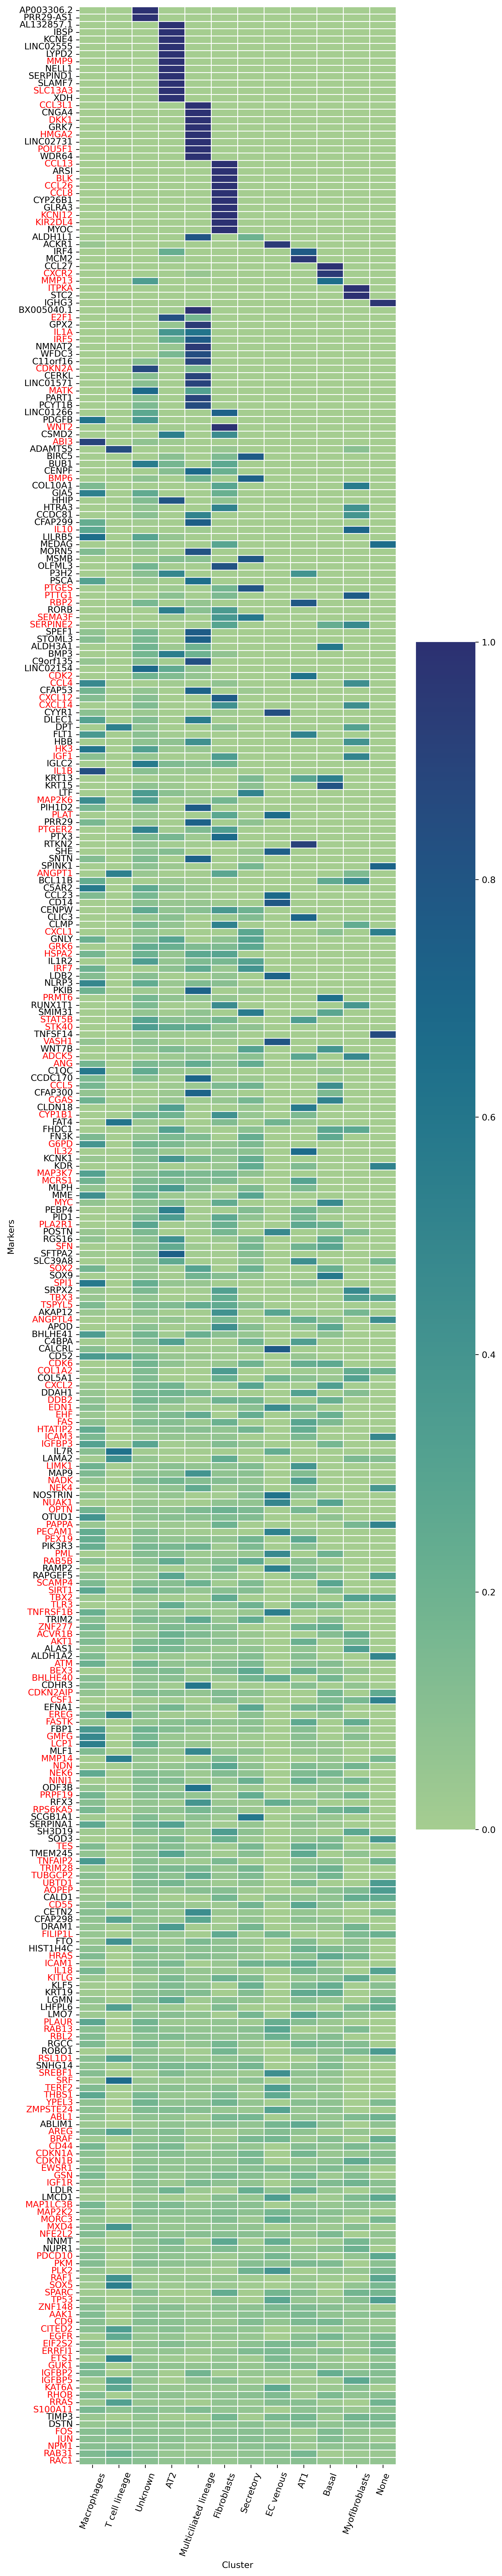

In [66]:
rows=[
 'AP003306.2',
 'PRR29-AS1',
    
 'AL132857.1',
 'IBSP',
 'KCNE4',
 'LINC02555',
 'LYPD2',
 'MMP9',
 'NELL1',
 'SERPIND1',
 'SLAMF7',
 'SLC13A3',
 'XDH',
    'CCL3L1',
    'CNGA4',
    'DKK1',
    'GRK7',
    'HMGA2',
    'LINC02731',
    'POU5F1',
    'WDR64',
    
    'CCL13',
    'ARSI',
    'BLK',
    'CCL26',
    'CCL8',
    'CYP26B1',
    'GLRA3',
    'KCNJ12',
    'KIR2DL4',
    'MYOC',
 
 'ALDH1L1',
 'ACKR1',
 'IRF4',
 'MCM2',
 'CCL27',
 'CXCR2',
 'MMP13',
    
 'ITPKA',
 'STC2',
 
    'IGHG3',
    'BX005040.1',
    'E2F1',
    'GPX2',
    'IL1A',
    'IRF5',
    'NMNAT2',
    'WFDC3',

    'C11orf16',
    
    
 'CDKN2A',
 'CERKL',
 
 
 
 'LINC01571',
 'MATK',
 
 
 
 'PART1',
 'PCYT1B',

 'LINC01266',
    
 'PDGFB',
 
         'WNT2',
     'CSMD2',
 'ABI3',
 
 'ADAMTS5',
 'BIRC5',
 
 'BUB1',
    'CENPF',
    'BMP6',
  'COL10A1',
 'GJA5',
 'HHIP',
 'HTRA3',
 'CCDC81',
 
 'CFAP299',

 
 'IL10',
 'LILRB5',
 
 'MEDAG',
 'MORN5',
 'MSMB',
 'OLFML3',
 'P3H2',
 'PSCA',
 'PTGES',
 'PTTG1',
 'RBP2',
 'RORB',
 'SEMA3F',
 'SERPINE2',
 'SPEF1',
 'STOML3',
 'ALDH3A1',
 'BMP3',
 'C9orf135',
    'LINC02154',
    'CDK2',
 'CCL4',
 
 'CFAP53',
 'CXCL12',
 'CXCL14',
 'CYYR1',
 'DLEC1',
 'DPT',
 'FLT1',
 'HBB',
 'HK3',
 'IGF1',
 'IGLC2',
 'IL1B',
 'KRT13',
 'KRT15',
 'LTF',
 'MAP2K6',
 'PIH1D2',
 'PLAT',
 'PRR29',
 'PTGER2',
 'PTX3',
 'RTKN2',
 'SHE',
 'SNTN',
 'SPINK1',
 'ANGPT1',
 'BCL11B',
 'C5AR2',
 'CCL23',
 'CD14',
 'CENPW',
 'CLIC3',
 'CLMP',
 'CXCL1',
 'GNLY',
 'GRK6',
 'HSPA2',
 'IL1R2',
 'IRF7',
 'LDB2',
 'NLRP3',
 'PKIB',
 'PRMT6',
 'RUNX1T1',
 'SMIM31',
 'STAT5B',
 'STK40',
 'TNFSF14',
 'VASH1',
 'WNT7B',
 'ADCK5',
 'ANG',
 'C1QC',
 'CCDC170',
 'CCL5',
 'CFAP300',
 'CGAS',
 'CLDN18',
 'CYP1B1',
 'FAT4',
 'FHDC1',
 'FN3K',
 'G6PD',
 'IL32',
 'KCNK1',
 'KDR',
 'MAP3K7',
 'MCRS1',
 'MLPH',
 'MME',
 'MYC',
 'PEBP4',
 'PID1',
 'PLA2R1',
 'POSTN',
 'RGS16',
 'SFN',
 'SFTPA2',
 'SLC39A8',
 'SOX2',
 'SOX9',
 'SPI1',
 'SRPX2',
 'TBX3',
 'TSPYL5',
 'AKAP12',
 'ANGPTL4',
 'APOD',
 'BHLHE41',
 'C4BPA',
 'CALCRL',
 'CD52',
 'CDK6',
 'COL1A2',
 'COL5A1',
 'CXCL2',
 'DDAH1',
 'DDB2',
 'EDN1',
 'EHF',
 'FAS',
 'HTATIP2',
 'ICAM3',
 'IGFBP3',
 'IL7R',
 'LAMA2',
 'LIMK1',
 'MAP9',
 'NADK',
 'NEK4',
 'NOSTRIN',
 'NUAK1',
 'OPTN',
 'OTUD1',
 'PAPPA',
 'PECAM1',
 'PEX19',
 'PIK3R3',
 'PML',
 'RAB5B',
 'RAMP2',
 'RAPGEF5',
 'SCAMP4',
 'SIRT1',
 'TBX2',
 'TLR3',
 'TNFRSF1B',
 'TRIM2',
 'ZNF277',
 'ACVR1B',
 'AKT1',
 'ALAS1',
 'ALDH1A2',
 'ATM',
 'BEX3',
 'BHLHE40',
 'CDHR3',
 'CDKN2AIP',
 'CSF1',
 'EFNA1',
 'EREG',
 'FASTK',
 'FBP1',
 'GMFG',
 'LCP1',
 'MLF1',
 'MMP14',
 'NDN',
 'NEK6',
 'NINJ1',
 'ODF3B',
 'PRPF19',
 'RFX3',
 'RPS6KA5',
 'SCGB1A1',
 'SERPINA1',
 'SH3D19',
 'SOD3',
 'TES',
 'TMEM245',
 'TNFAIP2',
 'TRIM28',
 'TUBGCP2',
 'UBTD1',
 'AOPEP',
 'CALD1',
 'CD55',
 'CETN2',
 'CFAP298',
 'DRAM1',
 'FILIP1L',
 'FTO',
 'HIST1H4C',
 'HRAS',
 'ICAM1',
 'IL18',
 'KITLG',
 'KLF5',
 'KRT19',
 'LGMN',
 'LHFPL6',
 'LMO7',
 'PLAUR',
 'RAB13',
 'RBL2',
 'RGCC',
 'ROBO1',
 'RSL1D1',
 'SNHG14',
 'SREBF1',
 'SRF',
 'TERF2',
 'THBS1',
 'YPEL3',
 'ZMPSTE24',
 'ABL1',
 'ABLIM1',
 'AREG',
 'BRAF',
 'CD44',
 'CDKN1A',
 'CDKN1B',
 'EWSR1',
 'GSN',
 'IGF1R',
 'LDLR',
 'LMCD1',
 'MAP1LC3B',
 'MAP2K2',
 'MORC3',
 'MXD4',
 'NFE2L2',
 'NNMT',
 'NUPR1',
 'PDCD10',
 'PKM',
 'PLK2',
 'RAF1',
 'SOX5',
 'SPARC',
 'TP53',
 'ZNF148',
 'AAK1',
 'CD9',
 'CITED2',
 'EGFR',
 'EIF2S2',
 'ERRFI1',
 'ETS1',
 'GUK1',
 'IGFBP2',
 'IGFBP5',
 'KAT6A',
 'RHOB',
 'RRAS',
 'S100A11',
 'TIMP3',
 'DSTN',
 'FOS',
 'JUN',
 'NPM1',
 'RAB31',
 'RAC1']



cols=sorted(list(outputs_dict.keys()))
cols_names=[celltype_names[i] for i in cols]

def get_matrix(rows,cols,outputs_dict):
    matrix=np.zeros((len(rows),len(cols)))

    for col_index in range(len(cols)):
        cluster=cols[col_index]
        genes=outputs_dict[cluster]
        for gene in genes:
            row_index=rows.index(gene)
            matrix[row_index][col_index]=1
            
    return matrix

def get_matrix_exp(rows,cols,outputs_dict):
    # cluster_cell_ls
    # gene_cell
    # gene_names
    # heatmap显示表达量
    matrix=np.zeros((len(rows),len(cols)))

    for col_index in range(len(cols)):
        cluster=cols[col_index]
        genes=outputs_dict[cluster]
        for gene in genes:
            row_index=rows.index(gene)
            cells=cluster_cell_dict[cluster]
            exp=sum(gene_cell[gene_names.index(gene)][cells])/len(cells)
            matrix[row_index][col_index]=exp
    for i,line in enumerate(matrix):
        matrix[i]=matrix[i]/sum(matrix[i])
    return matrix

matrix=get_matrix_exp(rows,cols,outputs_dict)


plt.figure(figsize=(8,50),dpi=300)

ax=sns.heatmap(matrix, cmap="crest",xticklabels=cols_names,yticklabels=rows,linewidth=.5)
plt.ylabel('Markers')
plt.xlabel("Cluster")
# plt.get_ticklines()
for tick in ax.get_xticklabels():
    tick.set_rotation(70)
    
indexs=[]
sen_gene_names=[gene_names[i] for i in sen_gene_ls]
for i,j in enumerate(rows):
    if j in sen_gene_names:
        indexs.append(i)
for i in indexs:
    ax.get_yticklabels()[i].set_color("red") 

# 2022-11-22 13:59:41.119 [DEBUG] [colorbar.py:620] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b7b0a9ea820>
# 2022-11-22 13:59:41.120 [DEBUG] [colorbar.py:665] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b7b0a9ea820> on colorbar
# 2022-11-22 13:59:41.121 [DEBUG] [colorbar.py:794] Setting pcolormesh


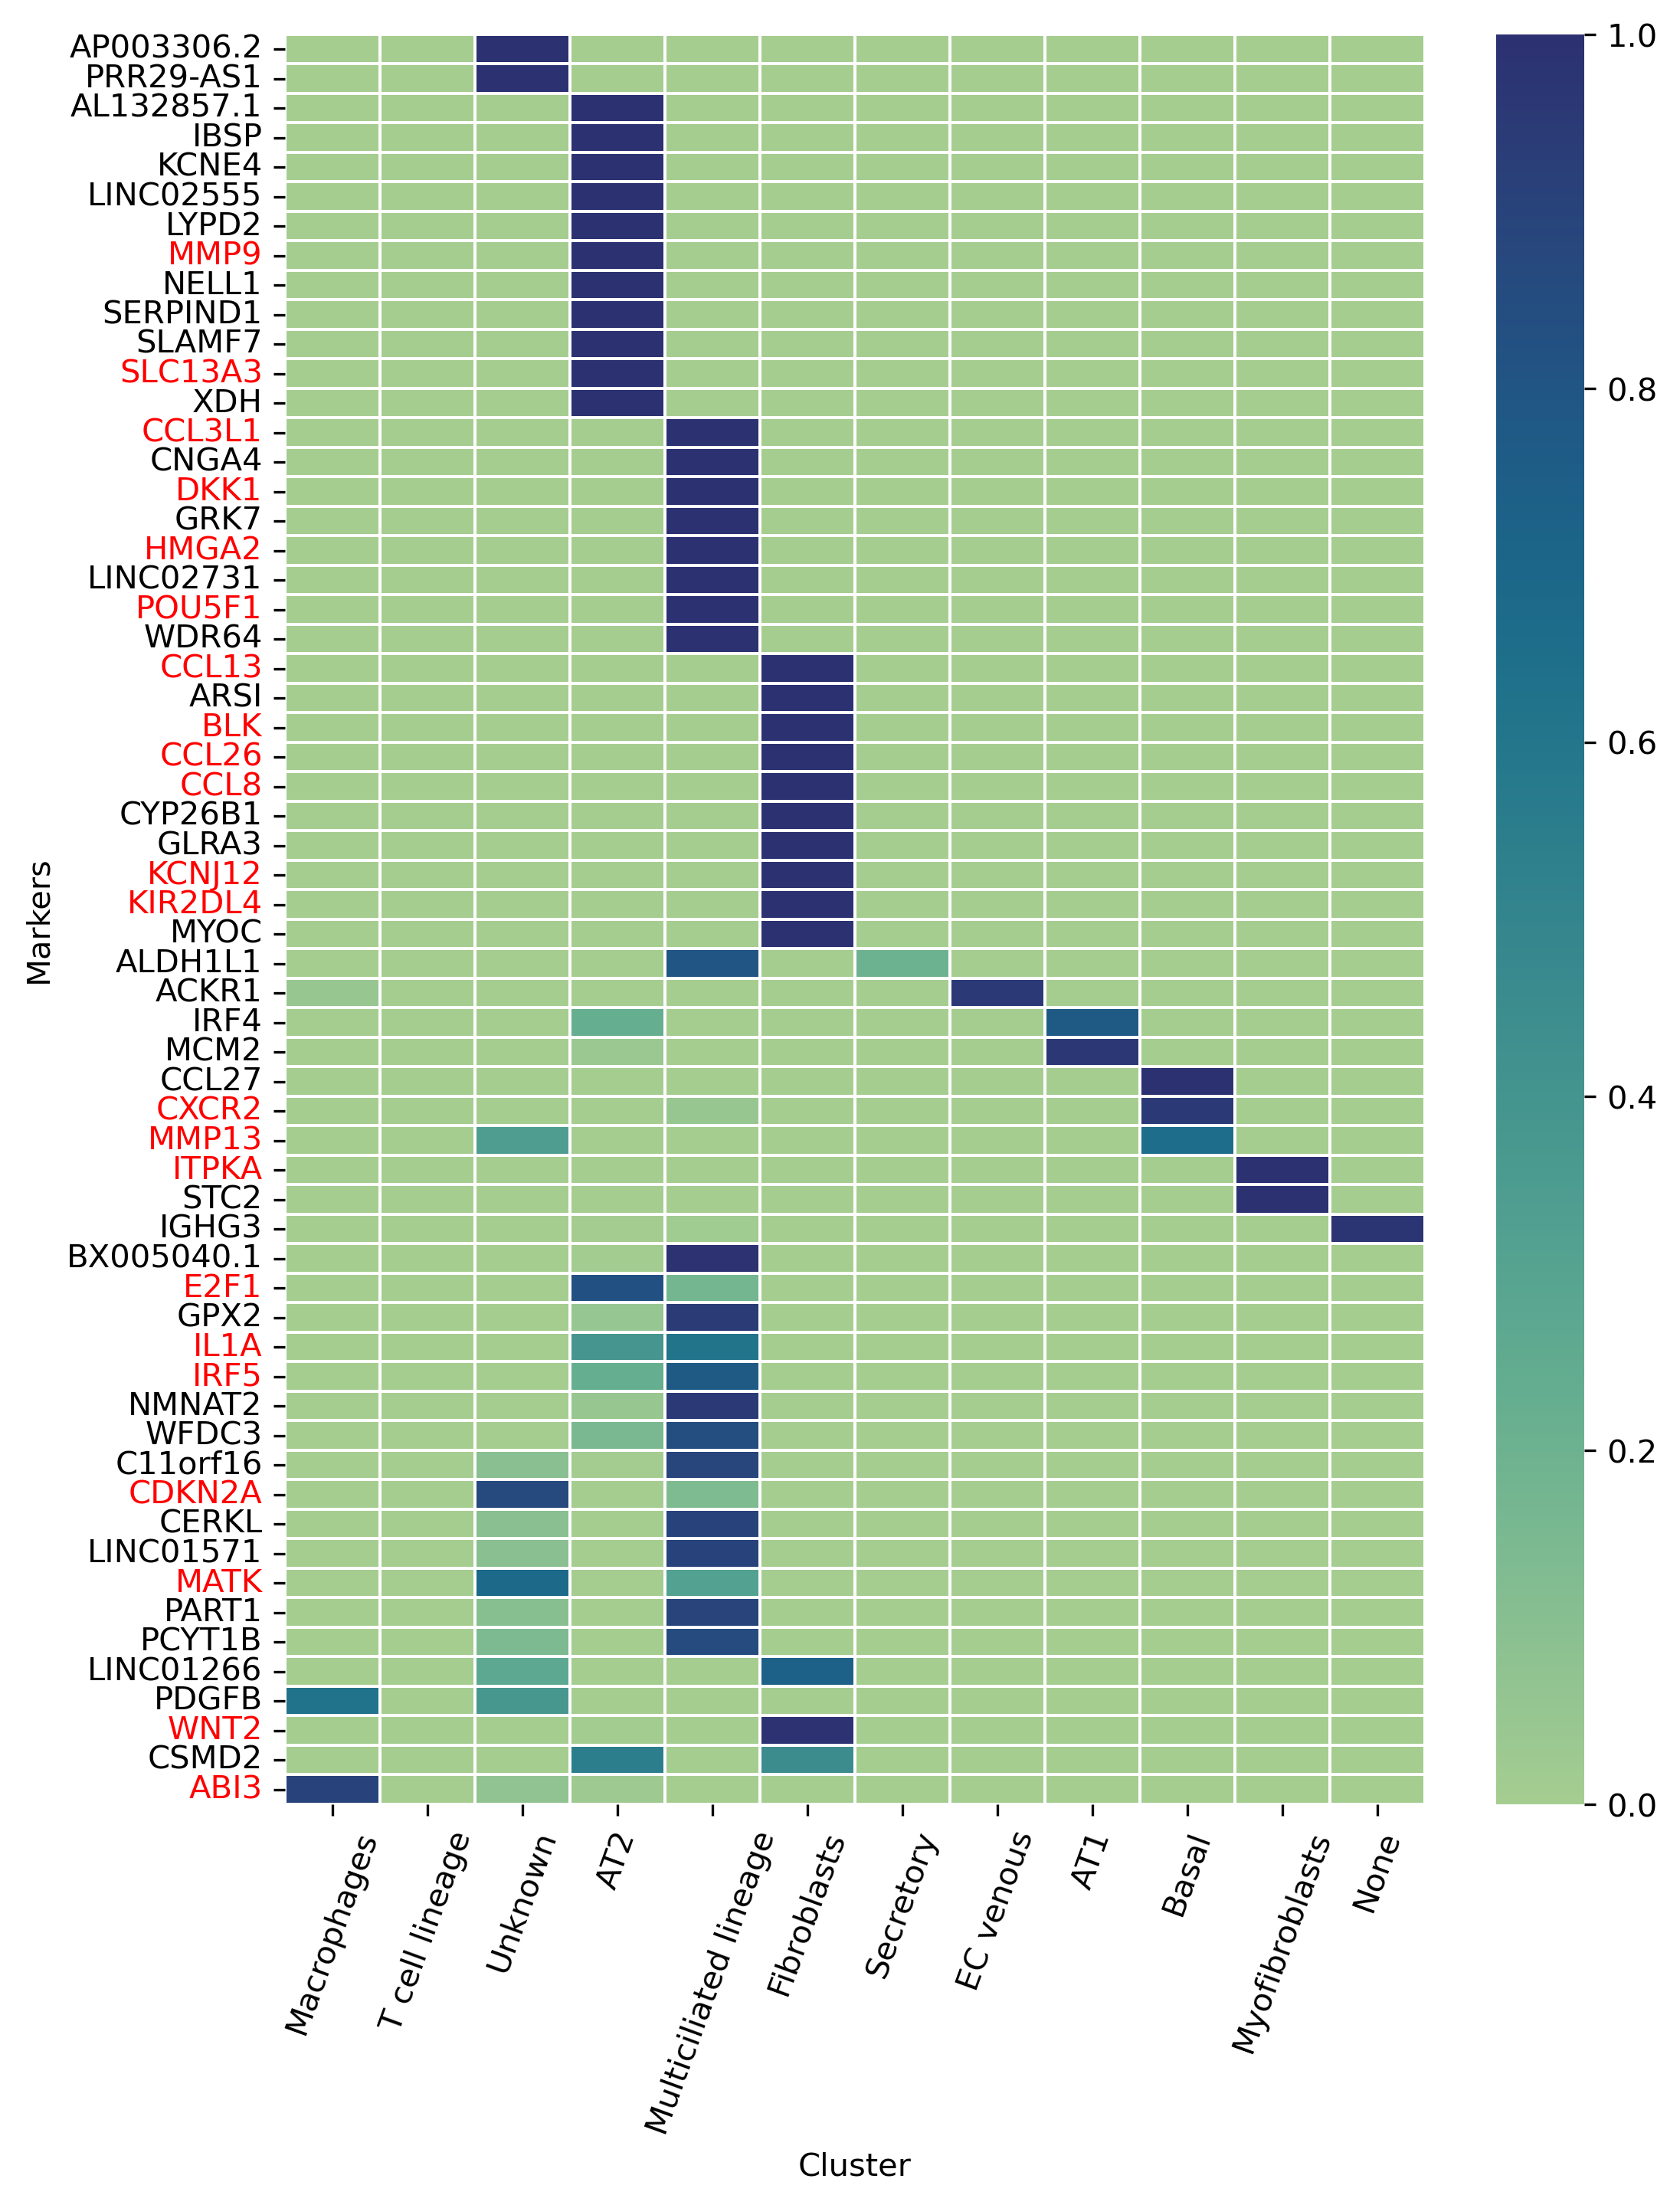

In [68]:
plt.figure(figsize=(8,10),dpi=300)

split=60
ax=sns.heatmap(matrix[:split,:], cmap="crest",xticklabels=cols_names,yticklabels=rows[:split],linewidth=.5)
plt.ylabel('Markers')
plt.xlabel("Cluster")
# plt.get_ticklines()
for tick in ax.get_xticklabels():
    tick.set_rotation(70)
for i in indexs:
    if i<split:
        ax.get_yticklabels()[i].set_color("red") 

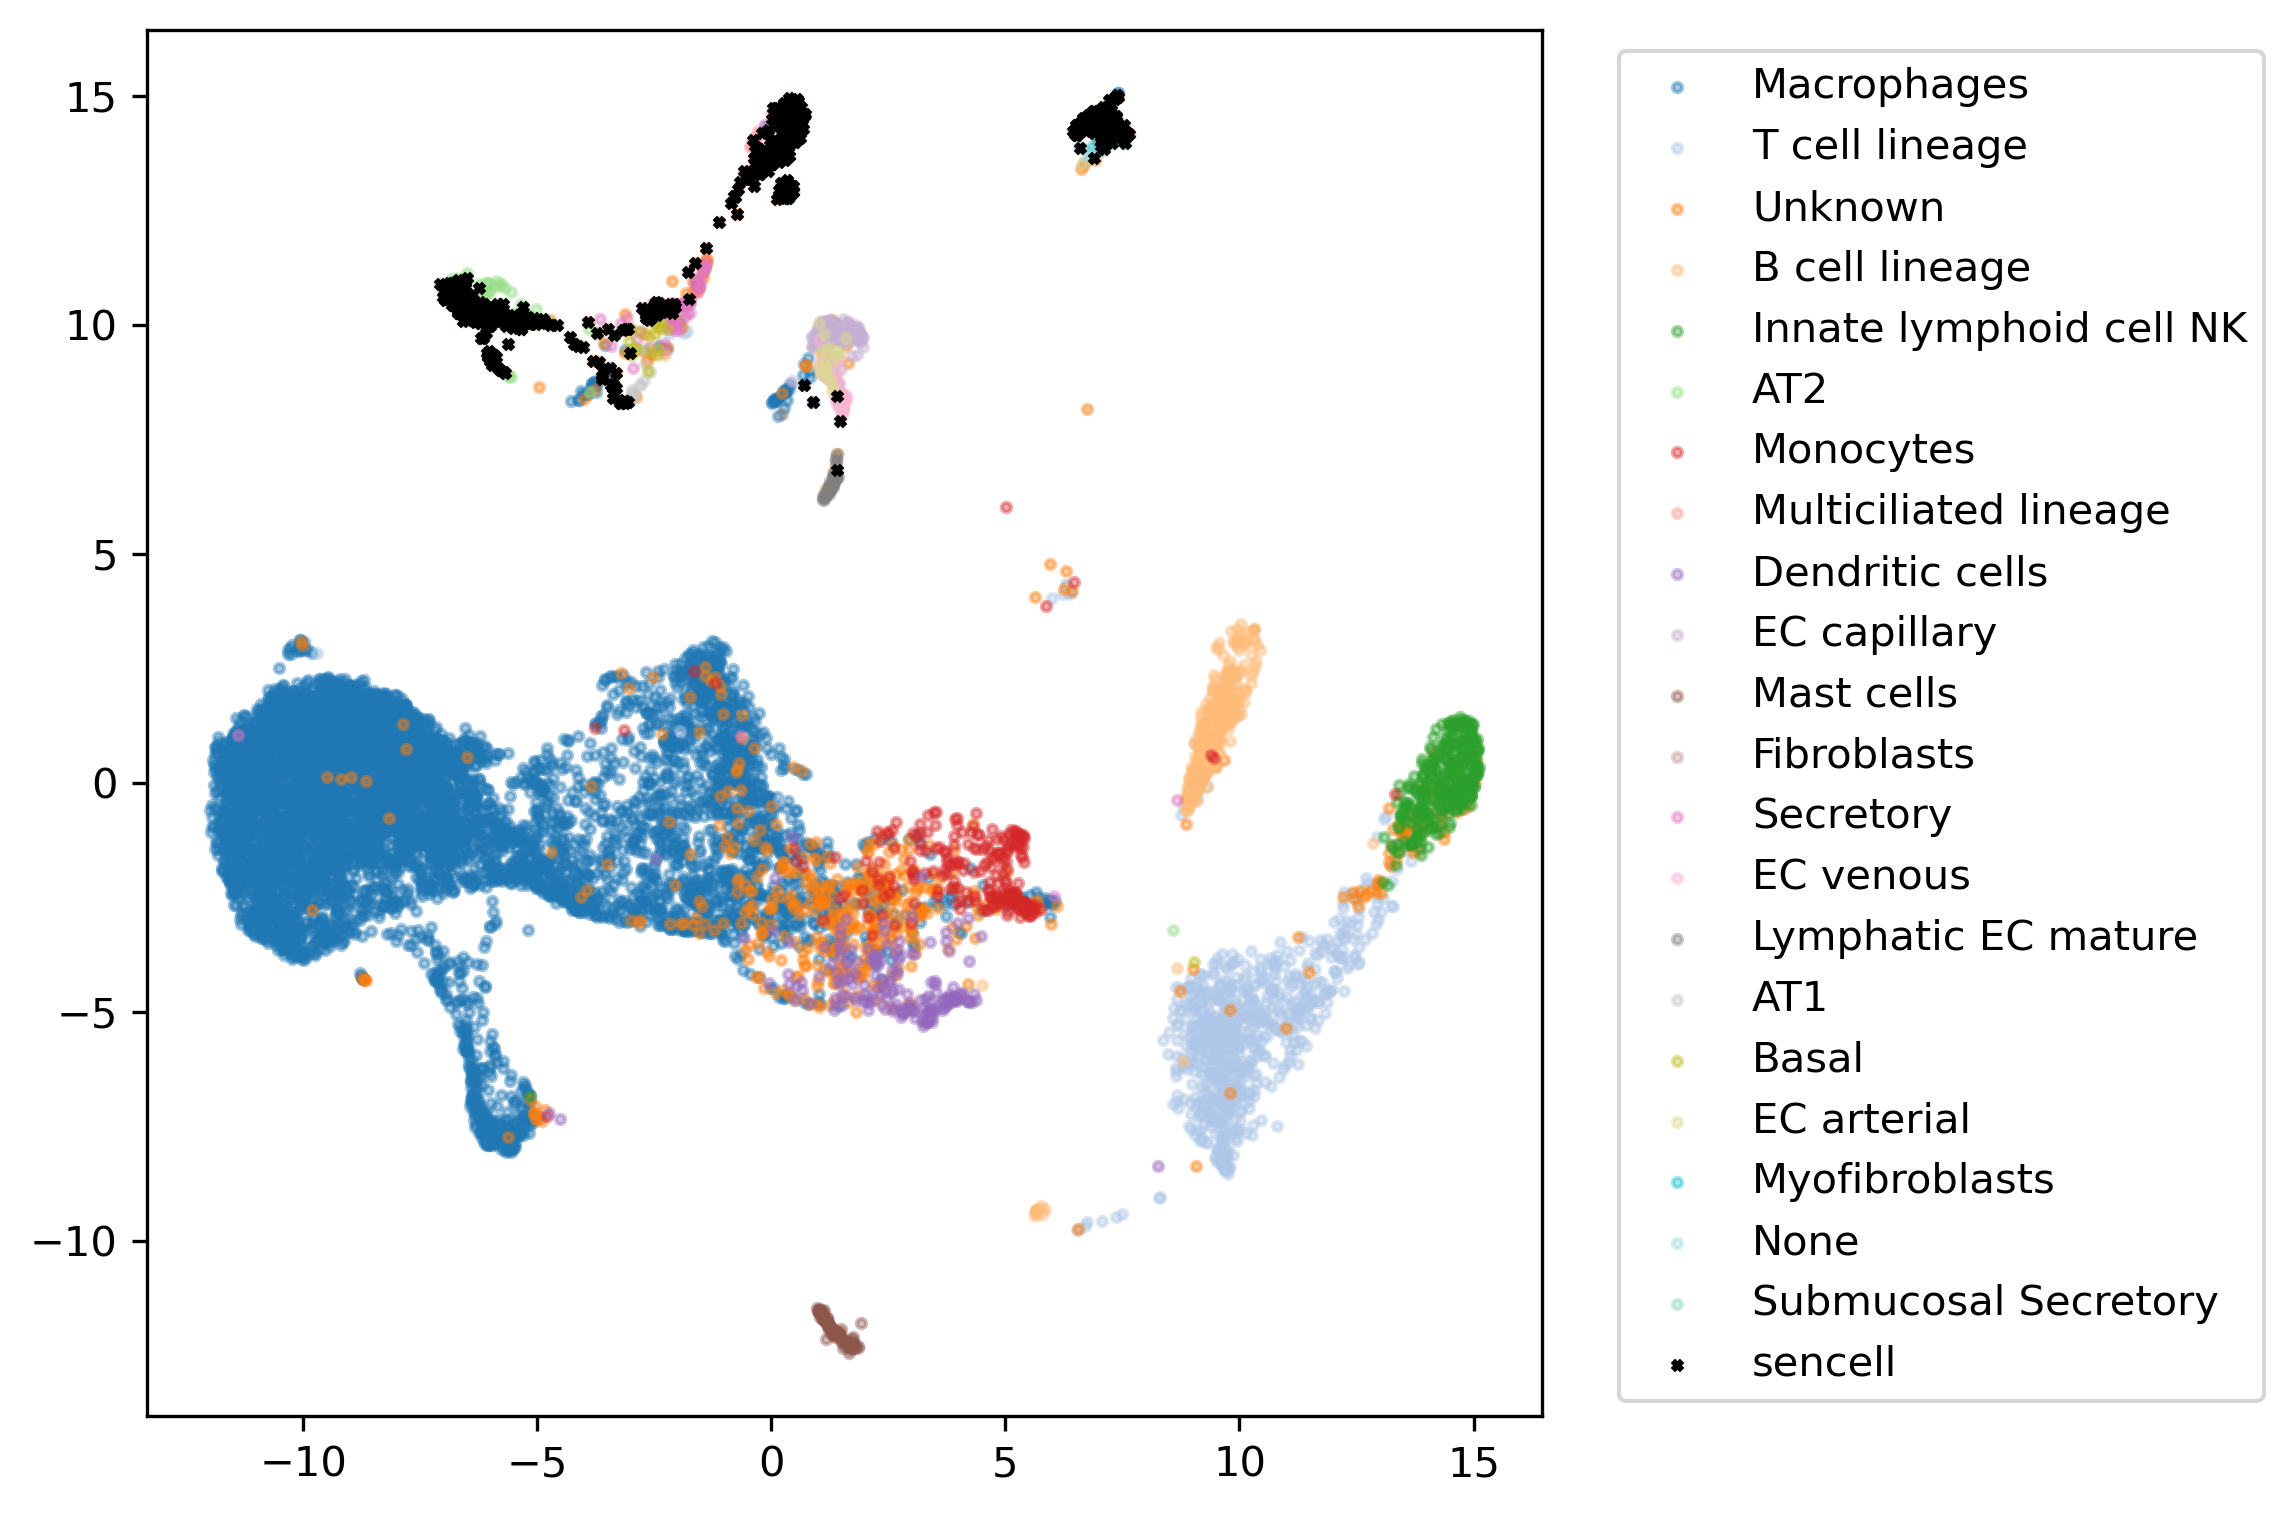

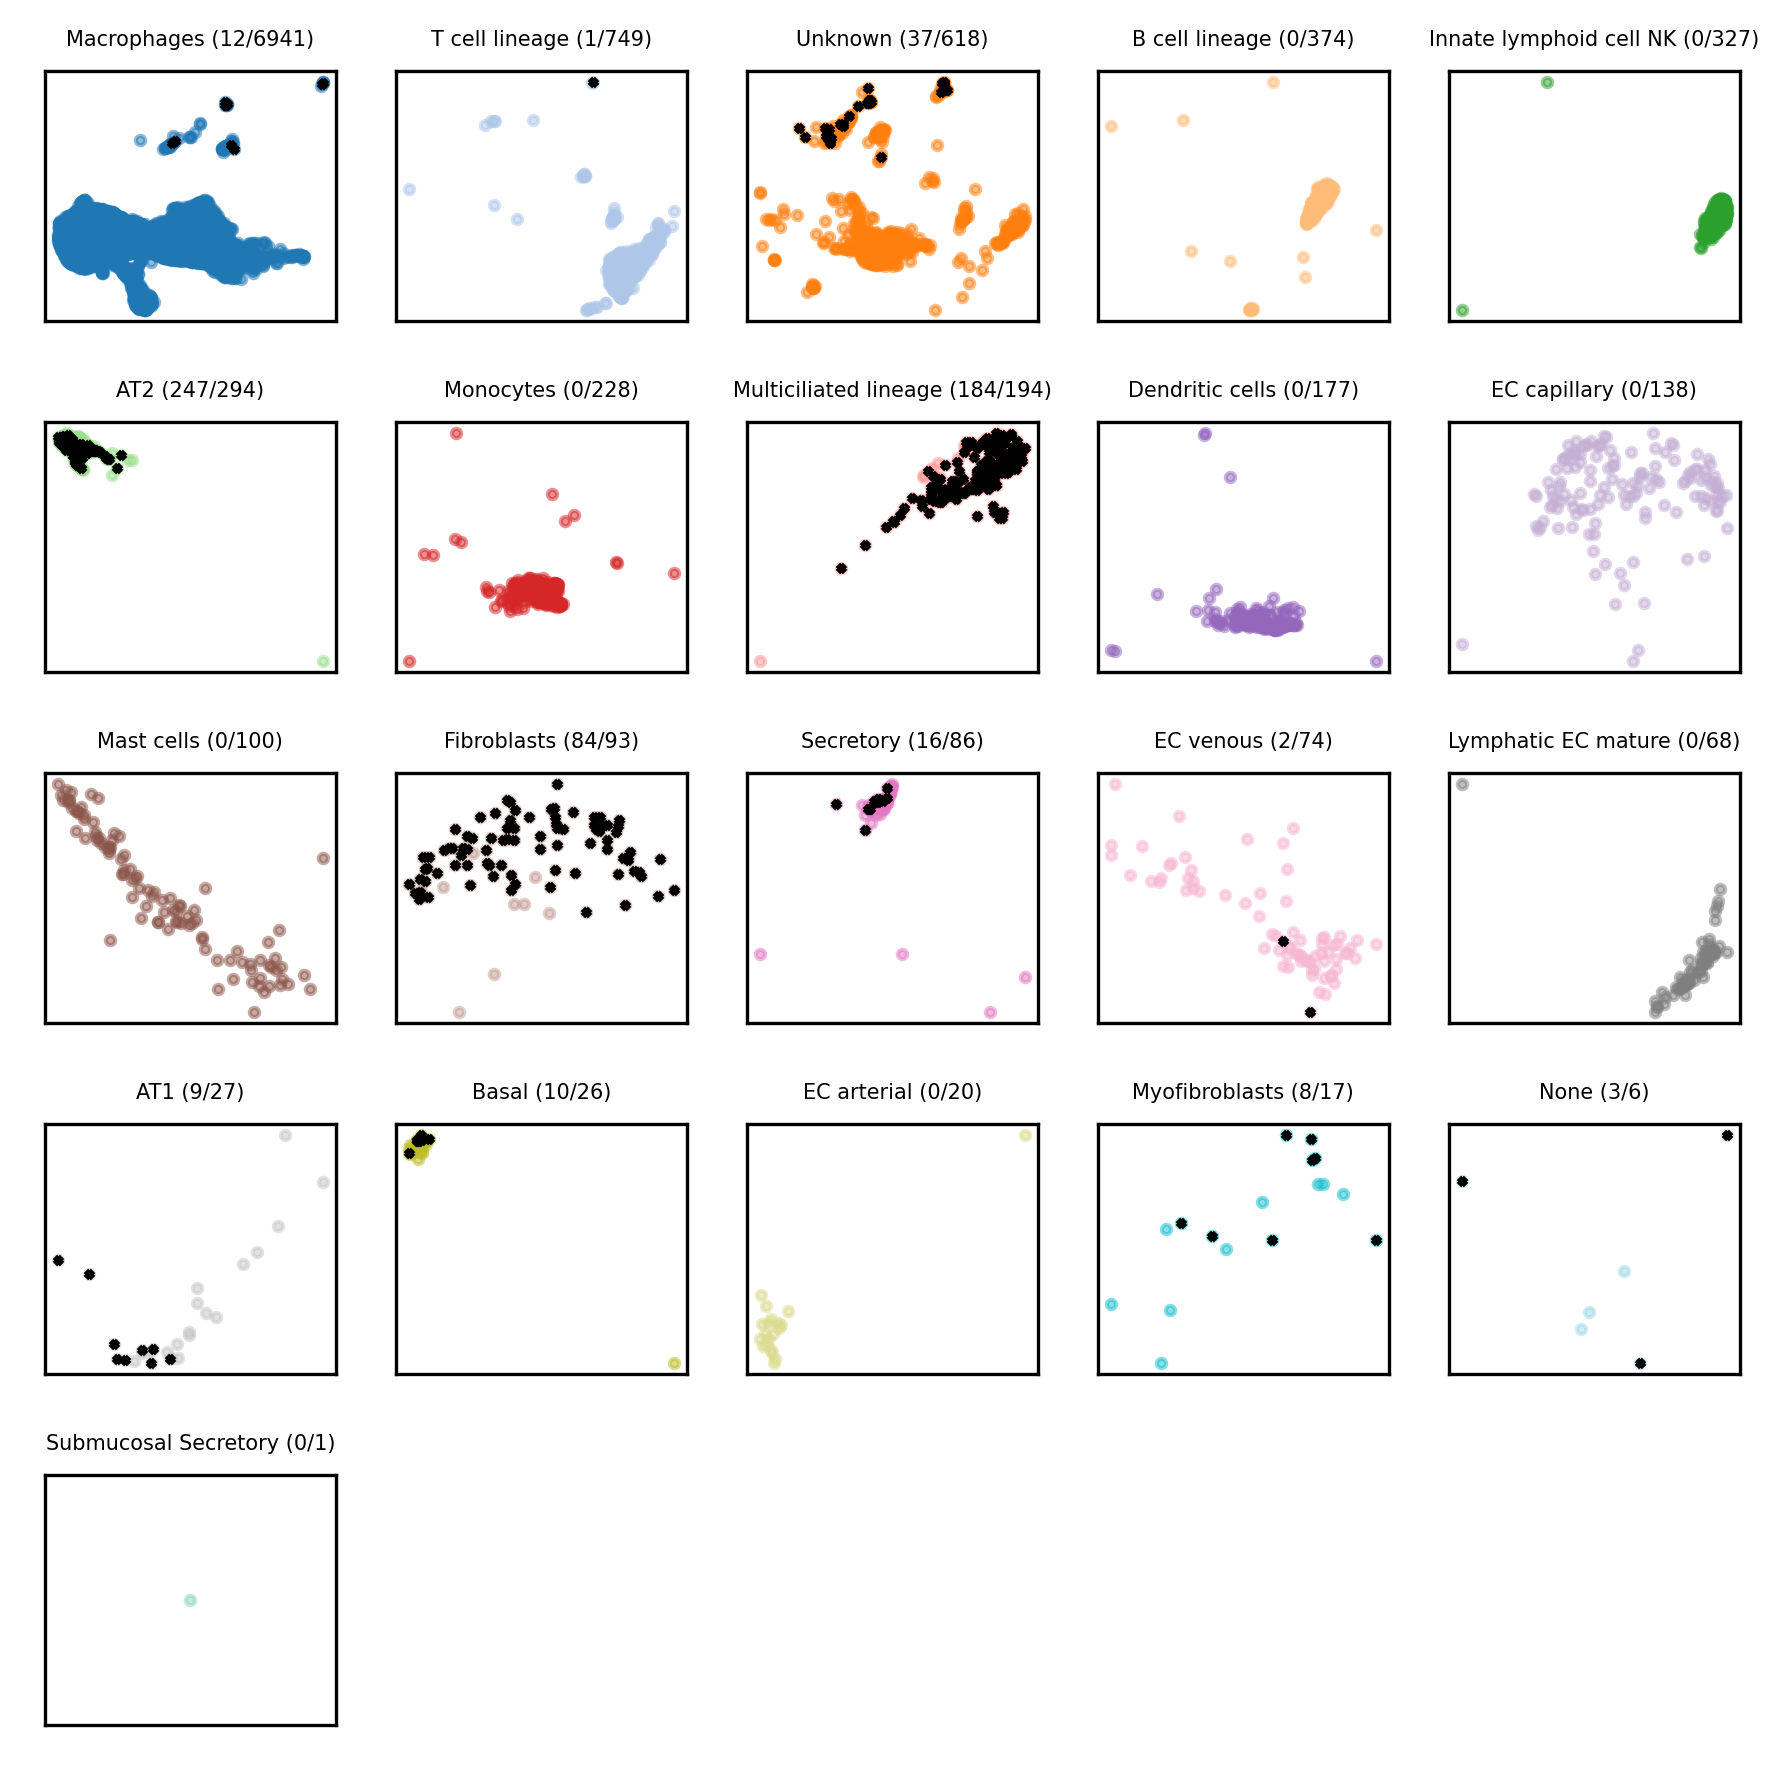

In [58]:
def umapPlot(embedding,cell_index_ls,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(embedding)
    
    plt.figure(figsize=(6,6),dpi=300)
    cmap1 = matplotlib.cm.get_cmap('tab20')        
    cmap2 = matplotlib.cm.get_cmap('Set3')  
    color_ls=cmap1.colors+cmap2.colors
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        for i,(cluster,label) in enumerate(zip(clusters,labels)):
            plt.scatter(embedding[cluster,0],embedding[cluster,1],alpha=0.4,s=5,color=color_ls[i],label=label)
            
        plt.scatter(embedding[cell_index_ls,0],embedding[cell_index_ls,1],s=5,color='black',marker='x',label='sencell')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

def subUmapPlot(embedding,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(embedding)
    
    fig, axes = plt.subplots(5, 5, sharex=False, sharey=False,figsize=(6,6),dpi=300)

    cmap1 = matplotlib.cm.get_cmap('tab20')        
    cmap2 = matplotlib.cm.get_cmap('Set3')  
    color_ls=cmap1.colors+cmap2.colors
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        x_s=[]
        y_s=[]
        label_s=[]
        for cluster,label in zip(clusters,labels):
            x_s.append(embedding[cluster,0])
            y_s.append(embedding[cluster,1])
            label_s.append(label)
        count=0
        for i, row in enumerate(axes):
            for j, col in enumerate(row):
                if count<21:
                    col.scatter(x_s[count],y_s[count],alpha=0.5,color=color_ls[count],s=5)
                    sencell_num=0
                    if count in cluster_cell_dict:
                        # 这一簇有老化细胞
                        col.scatter(embedding[cluster_cell_dict[count],0],embedding[cluster_cell_dict[count],1],
                                   s=3,color='black',marker='x',label='sencell')
                        sencell_num=len(cluster_cell_dict[count])
                        
                    col.set_title(f"{label_s[count]} ({sencell_num}/{len(clusters[count])})",fontsize=5)
                    count+=1
                else:
                    col.set_visible(False)
    plt.setp(fig.axes, yticks=[],xticks=[])
    
    plt.tight_layout()

        
umapPlot(adata.obsm['X_umap'],np.array(cell_index_ls),clusters=cluster_cell_ls,labels=celltype_names)
subUmapPlot(adata.obsm['X_umap'],clusters=cluster_cell_ls,labels=celltype_names)

In [63]:
cluster_cell_dict

{12: [7301,
  2273,
  6672,
  7686,
  9876,
  9445,
  9838,
  7795,
  9393,
  2713,
  9186,
  861,
  2607,
  6944,
  4807,
  10167],
 7: [7292,
  9852,
  3354,
  9344,
  8515,
  744,
  10345,
  9987,
  625,
  10222,
  3954,
  7911,
  889,
  6732,
  6650,
  1592,
  4336,
  1607,
  4955,
  2715,
  8003,
  10465,
  7759,
  10346,
  10303,
  8400,
  546,
  4291,
  1912,
  38,
  4912,
  6053,
  696,
  1329,
  6501,
  6243,
  651,
  5760,
  10480,
  10247,
  4876,
  4877,
  7030,
  4272,
  2151,
  4174,
  4036,
  4930,
  4596,
  8096,
  120,
  9096,
  7930,
  8171,
  3431,
  4103,
  4028,
  8111,
  7408,
  1953,
  2278,
  0,
  2731,
  9022,
  2742,
  5605,
  1560,
  7454,
  2616,
  8159,
  6290,
  4988,
  4067,
  594,
  7419,
  8115,
  1113,
  8189,
  8141,
  5128,
  6815,
  10504,
  5744,
  2394,
  2271,
  1759,
  9561,
  4513,
  7831,
  4686,
  4125,
  8813,
  4263,
  9469,
  305,
  5616,
  7203,
  75,
  9530,
  8,
  2698,
  3284,
  6324,
  2805,
  52,
  7717,
  7627,
  3826,
  261,
  93,
